<a href="https://colab.research.google.com/github/Eddysunday012/ASLRecognitionModel/blob/main/ASLRecognitionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

## Question 1 - Gesture Recognition using Convolutional Neural Networks
---
American Sign Language (ASL) is a complete, complex language that employs signs made by moving the hands combined with facial expressions and postures of the body. It is the primary language of many North Americans who are deaf and is one of several communication options used by people who are deaf or hard-of-hearing.

The hand gestures representing English alphabet are shown below. In this question, you will focus on classifying these hand gesture images using convolutional neural networks. Specifically, given an image of a hand showing one of the letters, we want to detect which letter is being represented.


<img src = 'https://drive.google.com/uc?id=1nRxq6yqDkmumUuePXfDx_5YgGl9vKXcj' width="300">






Run the following code cell to download the training and test data. It might take a while to download the zip file and extract it.

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import io
import zipfile
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1jDDjJzhZ7XV5DMRAEg23ymrz-IjnpGIO'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile('data.zip')

zip_ref = zipfile.ZipFile("data.zip", 'r')
with zipfile.ZipFile('./data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')
zip_ref.close()

###Part A) Understanding and Processing the Data

Now that you downloaded the data, you see two folders containing training and test data. Complete the following steps:

1) read in the training and test data. Examine the data folders carefully to see how file names and folder names represent different labels (29 labels in total) in the datasets.

2) rescale the pixel values of the training and test images from [0,255] to [0,1].

3) make sure that all of your imges are of size $200\times 200$. If not, scale them appropriately.

4) Ensure that your target values (classes) are stored appropriately. You must have 29 classes for 'a-z', 'del', 'nothing', and 'space'.

In [ ]:
import os
import string
import numpy as np
import shutil
from matplotlib import image
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical

label_map = dict(zip(string.ascii_uppercase, range(0,26)))
label_map['del'] = 26
label_map['nothing'] = 27
label_map['space'] = 28

directory_type = list(label_map.keys())

print(directory_type)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [ ]:
#Directories
train_directory = r'/content/asl_alphabet_train/asl_alphabet_train/'
test_directory = r'/content/asl_alphabet_test/asl_alphabet_test/'

In [ ]:
#function to count data in train directory
def count_asl_train_data(directory):
  img_count = 0
  for dir_type in directory_type:
    for filename in os.listdir(directory+dir_type):
      if filename.endswith("jpg"):
        img_count+=1
  return img_count

In [ ]:
count = count_asl_train_data(train_directory) / 29
train_num = count * 0.6
val_num = count * 0.2
test_num = count * 0.2

In [ ]:
#functions to load files in directory

#for training data
def load_train_asl_data(directory, start, end):
  X = np.empty((int(end-start), 200, 200, 3), dtype=np.uint8)
  y = np.empty((int(end-start),), dtype=np.uint8)

  for dir_type in directory_type:
    i = 0
    for filename in os.listdir(directory+dir_type)[int(start):int(end)]:
      if filename.endswith(".jpg"):
        img_dir = os.path.join(directory+dir_type, filename)
        X[i] = image.imread(img_dir)
        if X[i].shape != (200, 200, 3):
          print(filename)
        y[i] = label_map[dir_type]
        i+=1

  return X, y

#for test data
def load_test_asl_data(directory):
  X = []
  y = []

  count = 0
  for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
      img_dir = os.path.join(directory, filename)
      asl_img = image.imread(img_dir)
      if asl_img.shape != (200, 200, 3):
        print(filename)
      X.append(asl_img)
      y.append(count)
      count+=1

  y[26]+=1
  y[27]+=1

  return np.array(X), np.array(y)

In [ ]:
X_train, y_train = load_train_asl_data(train_directory, 0, train_num)
X_val, y_val = load_train_asl_data(train_directory, train_num, train_num+val_num)
X_test, y_test = load_train_asl_data(train_directory, train_num+val_num, train_num+val_num+test_num)

In [ ]:
#run to remove datasets as they are loaded into numpy arrays already
#%rm -rf asl_alphabet_test/
#%rm -rf asl_alphabet_train/

In [ ]:
y_train.shape

(1800,)

In [ ]:
#rescaling the data
X_train = X_train/255
X_test = X_test/255
X_val = X_val/255

print(X_train[0].max())
print(X_test[0].max())
print(X_val[0].max())

1.0
1.0
1.0


In [ ]:
y_train = to_categorical(y_train, 29)
y_test = to_categorical(y_test, 29)
y_val = to_categorical(y_val, 29)

print(y_test.shape)

(600, 29)


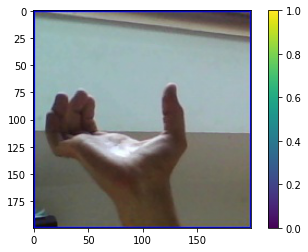

In [ ]:
plt.imshow(X_train[0])
plt.colorbar()
plt.show()

### Part B) Building a Convolutional Neural Network
For this assignment, we are not going to give you any starter code. You will be writing a convolutional neural network from scratch. You are welcome to use any code from previous class exercises, section handouts, and lectures. You should also write your own code.

You may use the TensorFlow documentation freely. You might also find online tutorials helpful. However, all code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unnecessary for loops). Ensure enough comments are included in the code so that your TA can understand what you are doing. It is your responsibility to show that you understand what you write.

Follow the steps below to show your work.

#### Step 1) Building the Network
Build a convolutional neural network model that takes the ($200\times 200$ RGB) image as input, and predicts the letter. Explain your choice of the architecture: how many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional? What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.layers import Dropout, Flatten, Activation, BatchNormalization,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D

import tensorflow as tf

In [ ]:
model = Sequential()

model.add(Input(shape=(200,200,3)))
model.add(Conv2D(60, (3,3), activation='relu'))
model.add(MaxPooling2D(2))

model.add(Conv2D(100, (3,3), activation='relu'))
model.add(MaxPooling2D(2))

model.add(Conv2D(50, (3,3), activation='relu'))
model.add(MaxPooling2D(2))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(len(label_map), activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 60)      1680      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 60)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 100)       54100     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 50)        45050     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 50)        0         
_________________________________________________________________
flatten (Flatten)            (None, 26450)             0

CNN in beginning

Flatten and dropout in the end

#### Step 2) Training the Network
Write code that trains your neural network given the training data. Your training code should make it easy to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice of loss function and optimizer.

Plot the training curve as well.

In [ ]:
opt = RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 60)      1680      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 60)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 100)       54100     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 50)        45050     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 50)        0         
_________________________________________________________________
flatten (Flatten)            (None, 26450)             0

In [ ]:
from keras_preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(train_directory,
                                                    target_size=(200,200),
                                                    batch_size=32,
                                                    class_mode='categorical',subset="training")

train_generator_val = train_datagen.flow_from_directory(train_directory,
                                                    target_size=(200,200),
                                                    batch_size=32,
                                                    class_mode='categorical',subset="validation")

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [ ]:
history = model.fit(train_generator, steps_per_epoch=60,validation_data=train_generator_val,validation_steps=20, epochs=100)

Epoch 1/100
60/60 [==============================] - 38s 154ms/step - loss: 3.4361 - accuracy: 0.0401 - val_loss: 3.3690 - val_accuracy: 0.0391
Epoch 2/100
60/60 [==============================] - 9s 150ms/step - loss: 3.3425 - accuracy: 0.0651 - val_loss: 3.2921 - val_accuracy: 0.0688
Epoch 3/100
60/60 [==============================] - 9s 149ms/step - loss: 3.1269 - accuracy: 0.1229 - val_loss: 3.1503 - val_accuracy: 0.1578
Epoch 4/100
60/60 [==============================] - 9s 150ms/step - loss: 2.8589 - accuracy: 0.1990 - val_loss: 2.9150 - val_accuracy: 0.2094
Epoch 5/100
60/60 [==============================] - 9s 149ms/step - loss: 2.5764 - accuracy: 0.2521 - val_loss: 2.7645 - val_accuracy: 0.2781
Epoch 6/100
60/60 [==============================] - 9s 149ms/step - loss: 2.3841 - accuracy: 0.3078 - val_loss: 2.6064 - val_accuracy: 0.2453
Epoch 7/100
60/60 [==============================] - 9s 149ms/step - loss: 2.2231 - accuracy: 0.3464 - val_loss: 2.4486 - val_accuracy: 0.276

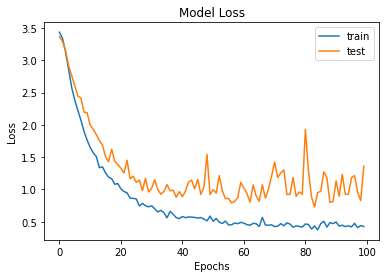

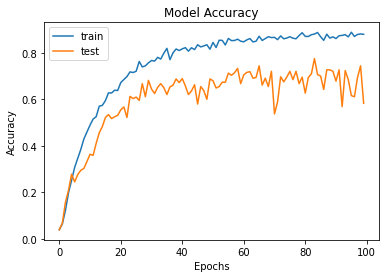

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'])
  plt.show()

def plot_acc(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(['train', 'test'])
  plt.show()

plot_loss(history)
plot_acc(history)

![picture](https://drive.google.com/file/d/1V1GT2iAvYwFBhnijWlcXTrw1_dLHIv0z/view?usp=sharing)

![picture](https://drive.google.com/file/d/1lDyuo63Yyihw1iTJBUM7fHyNGeyliyuW/view?usp=sharing)

In [ ]:
#run to remove datasets as they are loaded into numpy arrays already
%rm -rf asl_alphabet_test/
%rm -rf asl_alphabet_train/

[YOUR ANSWER HERE]

#### Step 3) Overfit to A Small Dataset

One way to sanity check our neural network model and training code is to check whether the model is capable of overfitting or memorizing a small dataset. A properly constructed CNN with correct training code should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. sample from the training data). Then show that your model and training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and a learning rate that is not too high, you should be able to obtain a 100% training accuracy on that small dataset relatively quickly.

In [ ]:
### YOUR CODE HERE ###
newhistory = model.fit(X_test, y_test, batch_size=200, epochs=100)

Epoch 1/100
3/3 [==============================] - 7s 801ms/step - loss: 0.3971 - accuracy: 0.9000
Epoch 2/100
3/3 [==============================] - 2s 800ms/step - loss: 0.0646 - accuracy: 0.9850
Epoch 3/100
3/3 [==============================] - 2s 796ms/step - loss: 0.0411 - accuracy: 0.9900
Epoch 4/100
3/3 [==============================] - 2s 800ms/step - loss: 0.0319 - accuracy: 0.9917
Epoch 5/100
3/3 [==============================] - 2s 803ms/step - loss: 0.0174 - accuracy: 0.9933
Epoch 6/100
3/3 [==============================] - 2s 798ms/step - loss: 0.0079 - accuracy: 1.0000
Epoch 7/100
3/3 [==============================] - 2s 802ms/step - loss: 0.0189 - accuracy: 0.9917
Epoch 8/100
3/3 [==============================] - 2s 792ms/step - loss: 0.0090 - accuracy: 0.9983
Epoch 9/100
3/3 [==============================] - 2s 800ms/step - loss: 0.0061 - accuracy: 0.9983
Epoch 10/100
3/3 [==============================] - 2s 794ms/step - loss: 0.0037 - accuracy: 1.0000
Epoch 11/

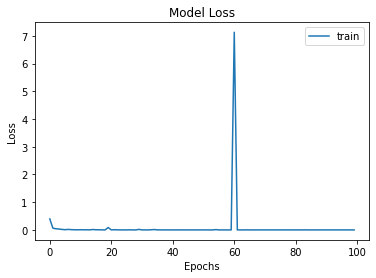

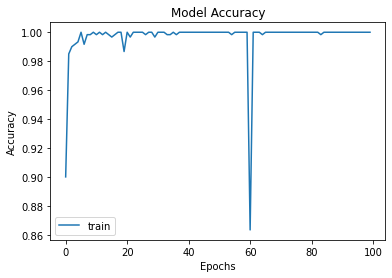

In [ ]:
plt.plot(newhistory.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(newhistory.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

#### Step 4) Hyperparameter Search

1. List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to the model architecture.

2. Tune the hyperparameters you listed previously, trying as many values as you need to until you feel satisfied that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

3. Choose the best model out of all the ones that you have trained. Justify your choice.

4. Report the test accuracy of your best model. You should only do this step once.







In [ ]:
#model 1
model_1 = Sequential()

model_1.add(Input(shape=(200,200,3)))
model_1.add(Conv2D(60, (3,3), activation='relu'))
model_1.add(MaxPooling2D(2))

model_1.add(Conv2D(100, (3,3), activation='relu'))
model_1.add(MaxPooling2D(2))

model_1.add(Conv2D(50, (3,3), activation='relu'))
model_1.add(MaxPooling2D(2))

model_1.add(Flatten())
model_1.add(Dense(100, activation='relu'))
model_1.add(Dropout(0.5))

model_1.add(Dense(len(label_map), activation="softmax"))

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 198, 198, 60)      1680      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 99, 99, 60)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 97, 97, 100)       54100     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 100)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 46, 46, 50)        45050     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 23, 23, 50)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 26450)            

**Loss and accuracy for this model:**


![picture](https://drive.google.com/file/d/1V1GT2iAvYwFBhnijWlcXTrw1_dLHIv0z/view?usp=sharing)

![picture](https://drive.google.com/file/d/1lDyuo63Yyihw1iTJBUM7fHyNGeyliyuW/view?usp=sharing)

In [ ]:
#model 2 with an lower learning rate and added batchnormalization
model_2 = Sequential()

model_2.add(Input(shape=(200,200,3)))
model_2.add(Conv2D(60, (3,3), activation='relu'))
model_2.add(MaxPooling2D(2))

model_2.add(Conv2D(100, (3,3), activation='relu'))
model_2.add(MaxPooling2D(2))
model_2.add(BatchNormalization())

model_2.add(Conv2D(50, (3,3), activation='relu'))
model_2.add(MaxPooling2D(2))

model_2.add(Flatten())
model_2.add(Dense(100, activation='relu'))
model_2.add(Dropout(0.3))

model_2.add(Dense(len(label_map), activation="softmax"))

model_2.summary()

**Loss and accuracy for this model:**


![picture](https://drive.google.com/file/d/1yQw1irr2U2Who_YLVMEYMGFsp72W5oRR/view?usp=sharing)

![picture](https://drive.google.com/file/d/12VplwB6mdi3yV_Z2iyB1UgIU0bW9N6Ws/view?usp=sharing)

In [ ]:
#model 3
#model 2 with an lower learning rate and higher dropout
model_3 = Sequential()

model_3.add(Input(shape=(200,200,3)))
model_3.add(Conv2D(60, (3,3), activation='relu'))
model_3.add(MaxPooling2D(2))

model_3.add(Conv2D(100, (3,3), activation='relu'))
model_3.add(MaxPooling2D(2))

model_3.add(Conv2D(50, (3,3), activation='relu'))
model_3.add(MaxPooling2D(2))

model_3.add(Flatten())
model_3.add(Dense(100, activation='relu'))
model_3.add(Dropout(0.7))

model_3.add(Dense(len(label_map), activation="softmax"))

model_3.summary()

**Loss and accuracy for this model:**


![picture](https://drive.google.com/file/d/1PVloMaVDjlrEGT11Z9ywzJQIPTskOf0I/view?usp=sharing)

![picture](https://drive.google.com/file/d/1byd5TSCtkkfZPgj5Ho3AMxVTMnf8_ZoV/view?usp=sharing)

The 3 hyperparameters I chose to adjust were learning rate, adding batch normalization, and Dropout rate.

Model 1 ended up becoming the most successful, with 99% accuracy on the training set and 85% on the validation set.


## Question 2 - Transfer Learning
---
For many image classification tasks, it is generally not a good idea to train a very large deep neural network model from scratch due to the enormous compute requirements and lack of sufficient amounts of training data.

One of the better options is to try using an existing model that performs a similar task to the one you need to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed Transfer Learning. In this assignment, we will use Transfer Learning to extract features from the hand gesture images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which get utilized by the fully connected layers for correct classification.


Keras even has pretrained models built in for this purpose.

#### Keras Pretrained Models
        Xception
        VGG16
        VGG19
        ResNet, ResNetV2, ResNeXt
        InceptionV3
        InceptionResNetV2
        MobileNet
        MobileNetV2
        DenseNet
        NASNet

Usually one uses the layers of the pretrained model up to some point, and then creates some fully connected layers to learn the desired recognition task. The earlier layers are "frozen", and only the later layers need to be trained. We'll use VGG16, which was trained to recognize 1000 objects in ImageNet. What we're doing here for our classifier may be akin to killing a fly with a shotgun, but the same process can be used to recognize objects the original network couldn't (i.e., you could use this technique to train your computer to recognize family and friends).

In [ ]:
# Some stuff we'll need...
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

Creating this pretrained network is a one line command. Notice we specified that the "top" should not be included. We aren't classifying 1000 different categories like ImageNet, so we don't include that layer. We'll add our own layer more suited to the task at hand.

We choose 224 as our image dimension because the pretrained VGG16 was trained using the ImageNet dataset which has images of this dimension.

In [ ]:
# Import the VGG16 trained neural network model, minus it's last (top) neuron layer.
base_model = VGG16(weights = 'imagenet',
                   include_top = False,
                   input_shape = (200, 200, 3),
                   pooling = None)

Let's take a look at this pretrained model:

In [ ]:
base_model.summary()

Please do realize, this may be overkill for our toy recognition task. One could use this network with some layers (as we're about to add) to recognize 100 dog breeds or to recognize all your friends. If you wanted to recognize 100 dog breeds, you would use a final 100 neuron softmax for the final layer. We'll need a final softmax layer as before. First let's freeze all these pretrained weights. They are fine as they are.

In [ ]:
# This freezes the weights of our VGG16 pretrained model.
for layer in base_model.layers:
    layer.trainable = False

### Part A) Building the Classifier
Now let's just add a flatten layer, a trainable dense layer, and a final softmax layer to the network to complete the classifier model for our gesture recognition task. Use Keras' functional approach to building a network.

In [ ]:
# Now add layers to our pre-trained base model and add classification layers on top of it
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation = 'relu')(x)
x = Dense(len(label_map), activation = 'softmax')(x) ### YOUR CODE HERE ###

# And now put this all together to create our new model.
model = Model(inputs = base_model.input, outputs = x)
model.summary()

### Part B) Initializing Training Parameters

Compile the model using an appropriate loss function and optimizer.

In [ ]:
# Compile the model.
model.compile(### YOUR CODE HERE ###
              loss = 'categorical_crossentropy',
              optimizer = Adagrad(lr = 0.001),
              metrics = ['acc'])

### Part C) Training the Model

Train your new network, including any hyperparameter tuning. Plot the training curve of your best model only.

As you can see here in the Keras docs:

https://keras.io/api/applications/vgg/#vgg16-function

that we are required to preprocess our image data in a specific way to use this pretrained model, so let's go ahead and do that first.

In [ ]:
# Preprocess your input image data

X_transfer_train = preprocess_input(X_train)

In [ ]:
# Train the model

history = model.fit(train_generator, steps_per_epoch=60,validation_data=train_generator_val,validation_steps=20, epochs=100)

In [ ]:
# Plot the training curve

plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

### Part D) Your Best Classifier

Add on your own last layers to the pretrained model and train it on the training data (in the previous parts you could have only one flatten layer and one dense layer to do the classification). You can increase (or decrease) the number of nodes per layer, increase (or decrease) the number of layers, and add dropout if your model is overfitting, change the hyperparameters, change your optimizer, etc. Try to get the validation accuracy higher than what the previous transfer learning model was able to obtain, and try to minimize the amount of overfitting.

Plot the classification accuracy for each epoch. Report the best test accuracy your model was able to achieve.

In [ ]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.35)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.35)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.35)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.35)(x)

x = Dense(len(label_map), activation = 'softmax')(x)
model = Model(inputs = base_model.input, outputs = x)
model.summary()

Training Acc: 93%
